In [163]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from sklearn.metrics import mean_squared_error
from nelson_siegel_svensson.calibrate import calibrate_ns_ols
from nelson_siegel_svensson import NelsonSiegelCurve

In [ ]:
# установить пакет с реализацией модели Нельсона - Сигеля
!pip install nelson_siegel_svensson

In [111]:
# Создать датафрейм для решения системы уравнений
data = {
'Рыночная цена': [987.9, 972.81, 966.99, 889.49, 917.95, 920.56, 924.49, 922.59, 844.97, 865.0, 814.85, 820.0, 826.60, 901.49, 838.29, 739.49, 852.0, 894.0, 792.91, 910.90, 752.0, 659.99, 704.5, 881.54, 728.5, 670.0 ],
'Срок до погашения, дн': [68, 206, 297, 570, 689, 997, 1018, 1137, 1382, 1487, 1606, 1907, 1977, 2075, 2299, 2635, 2824, 3251, 3377, 3734, 3790, 4224, 4602, 5260, 5561, 6352],
'Номинал': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000],
'Сумма купона': [32.41, 36.90, 35.40, 22.44, 35.65, 38.64, 39.64, 40.64, 29.92, 35.15, 28.42, 33.41, 34.41, 44.88, 38.15, 29.42, 42.38, 47.37, 38.39, 47.47, 36.15, 30.42, 34.90, 48.87, 38.39, 35.40],
'Срок до выплаты купона, дн': [[68], [26, 206], [117, 297], [26, 206, 386, 570],[145, 325, 505, 689],[89, 269, 449, 629, 809, 997],[110, 290, 470, 650, 830, 1018],[1137],[1382],[1487],[1606],[1977],[2075],[2299],[2635],[2824],[3251],[3377],[3734],[3790],[4224],[4602],[5260],[5561],[6352],[]]
}

1. $985,6 = \dfrac{1032,41}{(1 - t_1)^{\frac{68}{365}}}$

2. $969,9 = \dfrac{36,90}{(1 - t_1)^{\frac{26}{365}}} + \dfrac{1036,9}{(1 - t_2)^{\frac{201}{365}}}$

3. $963,2 = \dfrac{35,40}{(1 - t_2)^{\frac{117}{365}}} + \dfrac{1035,40}{(1 - t_3)^{\frac{293}{365}}}$

4. $888,1 = \dfrac{22,44}{(1 - t_1)^{\frac{26}{365}}} + \dfrac{22,44}{(1 - t_2)^{\frac{206}{365}}} + \dfrac{22,44}{(1 - t_3)^{\frac{386}{365}}} + \dfrac{1022,44}{(1 - t_4)^{\frac{545}{365}}}$

In [112]:
df = pd.DataFrame(data)

In [114]:
# решения системы уравнений соответствуют расчетной доходности ОФЗ на Московской Бирже
df['Расчетная доходность'] = pd.read_csv('moex_g.csv', delimiter= ';')['Расчетная доходность']

In [115]:
# Приводим срок в днях в срок в годах
df['Срок, лет'] = (df['Срок до погашения, дн']/365).round(2)

In [116]:
df.head(5)

,Рыночная цена,"Срок до погашения, дн",Номинал,Сумма купона,"Срок до выплаты купона, дн",Расчетная доходность,"Срок, лет"
0,987.90,68,1000,32.41,[68],14.27,0.19
1,972.81,206,1000,36.90,"[26, 206]",13.01,0.56
2,966.99,297,1000,35.40,"[117, 297]",11.99,0.81
3,889.49,570,1000,22.44,"[26, 206, 386, 570]",13.12,1.56
4,917.95,689,1000,35.65,"[145, 325, 505, 689]",12.69,1.89


Так как G - кривая получена при помощи добавления к модели Нельсона – Зигеля трех корректирующих членов для более точного описания начального участка кривой спот-ставок, расчитаем базовую моджель

In [117]:
# Создаем ряды данных для модели Нельсона - Зигеля
x = np.array(df['Срок, лет'])
y = np.array(df['Расчетная доходность'])

In [118]:
# Сгенерируем модель Нельсона - Зигеля
curve, status = calibrate_ns_ols(x, y, tau0=1.0)  # starting value of 1.0 for the optimization of tau
assert status.success


In [119]:
curve

NelsonSiegelCurve(beta0=12.101287349978914, beta1=2.12978394298701, beta2=-4.073966602593253, tau=1.4457196812522648)

In [120]:
y_ns = curve
t_ns = np.linspace(0.01, 17, 100)


In [121]:
term = np.array(df['Срок, лет'])
y_moex = np.array(df['Расчетная доходность'])

In [122]:
mean_squared_error(df['Срок, лет'], df['Расчетная доходность'])

53.12345769230769

In [123]:
def g_curve_model(t, params):

    beta0, beta1, beta2, tau1, g1, g2, g3, g4, g5, g6, g7, g8, g9 = params

    k = 1.6
    a1 = 0
    a2 = 0.6
    a3 = a2 + a2 * k**1
    a4 = a3 + a2 * k**2
    a5 = a4 + a2 * k**3
    a6 = a5 + a2 * k**4
    a7 = a6 + a2 * k**5
    a8 = a7 + a2 * k**6
    b1 = a2
    b2 = b1 * k
    b3 = b2 * k
    b4 = b3 * k
    b5 = b4 * k
    b6 = b5 * k
    b7 = b6 * k
    b8 = b7 * k

    return beta0 + (beta1 + beta2)*(tau1/t)*(1 - np.exp(-t/tau1)) - beta2*np.exp(-t/tau1) + g1*np.exp(-((t-a1)**2)/b1**2) + g2*np.exp(-((t-a2)**2)/b2**2)+ g3*np.exp(-((t-a3)**2)/b3**2) + g4*np.exp(-((t-a4)**2)/b4**2) + g5*np.exp(-((t-a5)**2)/b5**2) + g6*np.exp(-((t-a6)**2)/b6**2) + g7*np.exp(-((t-a7)**2)/b7**2) + g8*np.exp(-((t-a8)**2)/b8**2)




In [124]:
t = np.linspace(0.01, 17, 100)

In [125]:
params = [1191.0, 336.00, -374.43, 0.32,	0.48,	-0.95,	8.35,	-1.83,	-2.28,	-1.22,	-0.77,	0.00, 0.00]

In [126]:
result = (g_curve_model(t, params)/100).round(2)

In [127]:
data1 = {'t': np.linspace(0.01, 17, 100), 'Y' :[(g_curve_model(t, params)/100).round(2) for t in np.linspace(0.01, 17, 100)] }

In [128]:
df1 = pd.DataFrame(data1)

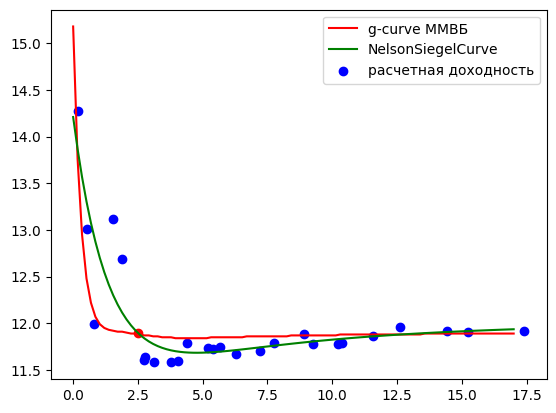

In [168]:
plt.plot(df1['t'], df1['Y'], label = 'g-curve ММВБ', color = 'r')
plt.plot(t_ns, y_ns(t), label = 'NelsonSiegelCurve', color = 'g')
# plt.plot(df2['x'], df2['y2'], label = 'y2 = 10 -x')
plt.scatter(df['Срок, лет'], df['Расчетная доходность'], color = 'b', label = 'расчетная доходность' )
plt.scatter(2.5, y_ns(2.5), color = 'red', label = 'точка смены модели' )
plt.legend()
plt.show()

In [133]:
df1['diff'] = df1['Y'] - df['Расчетная доходность']

# Возведение разности в квадрат
df1['diff_square'] = df1['diff'] ** 2

# Расчет средней квадратичной ошибки
mse = df1['diff_square'].mean()

mse

0.1484846153846153

In [173]:
t_1 = np.linspace(0.01, 2.5, 100)

In [175]:
data_2 = {'t': np.linspace(0.01, 2.5, 100), 'Y' :[(g_curve_model(t_1, params)/100).round(2) for t_1 in np.linspace(0.01, 2.5, 100)]}

In [176]:
df2 = pd.DataFrame(data_2)

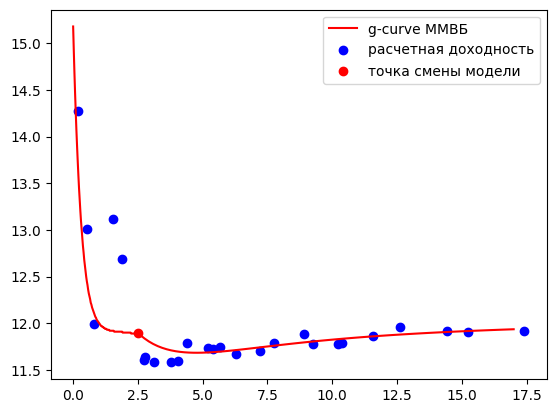

In [199]:
plt.plot(df2['t'], df2['Y'], label = 'g-curve ММВБ', color = 'r')
plt.plot(t_ns[t >= 2.5], y_ns(t)[t >= 2.5], color = 'r')
plt.scatter(df['Срок, лет'], df['Расчетная доходность'], color = 'b', label = 'расчетная доходность' )
plt.scatter(2.5, y_ns(2.5), color = 'red', label = 'точка смены модели' )
plt.legend()
plt.show()